In [1]:
# main.py
# Entry point for running the backtest

import pandas as pd

# Core components
from engine.multi_data_handler import MultiDataHandler
from engine.execution_handler import ExecutionHandler
from engine.portfolio import Portfolio

# Strategies
from strategies.momentum_strategy import MomentumStrategy
from strategies.pairs_strategy import PairsTradingStrategy

# Performance & risk
from utils.performance import (
    calculate_returns, calculate_sharpe_ratio,
    calculate_drawdowns, plot_equity_curve
)
from utils.risk import historical_var, expected_shortfall

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
print("Starting Algorithmic Trading Backtester 🚀")

# 1) Parameters
symbols    = ["AAPL","MSFT","GOOG","AMZN"]          # for your momentum example
start_date = "2020-01-01"
end_date   = "2025-01-01"
initial_cap = 100_000

Starting Algorithmic Trading Backtester 🚀


In [3]:
# 2) Load multi‐asset data
data_handler = MultiDataHandler(symbols, start_date, end_date)
price_data   = data_handler.load_data()            # dict of DataFrames

In [4]:
# 3) Choose & generate signals
strat = MomentumStrategy(lookback=90, top_k=2, bottom_k=2)
signals = strat.generate_signals(price_data)
# signals is a DataFrame indexed by date, columns=symbols, values in {+1,0,-1}


In [5]:
# 4) Setup backtest engine
exec_h = ExecutionHandler(commission_per_trade=1.0, slippage_pct=0.0005)
port   = Portfolio(initial_capital=initial_cap)

In [6]:
# 5) Run the backtest
# track daily total portfolio value
port_values = []

# Remember previous signal per symbol to trade only on changes
prev_sigs = {sym: 0 for sym in symbols}

for date in signals.index:
    today_prices = {sym: price_data[sym].loc[date, "Close"] for sym in symbols}
    today_sigs   = signals.loc[date]

    # loop each asset
    for sym in symbols:
        sig  = int(today_sigs[sym])
        prev = prev_sigs[sym]
        price = today_prices[sym]

        # BUY signal only on crossover up
        if sig == 1 and prev != 1:
            exec_h.execute_order("BUY", sym, 10, price, date)
            port.buy(sym, 10, price, commission=exec_h.commission)

        # SELL signal only on crossover down
        elif sig == -1 and prev != -1:
            exec_h.execute_order("SELL", sym, 10, price, date)
            port.sell(sym, 10, price, commission=exec_h.commission)

        prev_sigs[sym] = sig

    # record portfolio value after all trades that day
    total_val = port.value(today_prices)
    port_values.append((date, total_val))

SELL 10 AAPL @ 75.74 (comm: 1.00, slip: 0.04)
BUY 10 MSFT @ 174.78 (comm: 1.00, slip: 0.09)
SELL 10 GOOG @ 68.43 (comm: 1.00, slip: 0.03)
BUY 10 AMZN @ 117.91 (comm: 1.00, slip: 0.06)
BUY 10 AAPL @ 81.78 (comm: 1.00, slip: 0.04)
SELL 10 MSFT @ 178.70 (comm: 1.00, slip: 0.09)
BUY 10 GOOG @ 80.71 (comm: 1.00, slip: 0.04)
SELL 10 AMZN @ 151.73 (comm: 1.00, slip: 0.08)
SELL 10 AAPL @ 132.36 (comm: 1.00, slip: 0.07)
BUY 10 MSFT @ 236.46 (comm: 1.00, slip: 0.12)
SELL 10 MSFT @ 268.72 (comm: 1.00, slip: 0.13)
BUY 10 AMZN @ 186.66 (comm: 1.00, slip: 0.09)
BUY 10 MSFT @ 272.44 (comm: 1.00, slip: 0.14)
SELL 10 AMZN @ 183.78 (comm: 1.00, slip: 0.09)
BUY 10 AAPL @ 146.23 (comm: 1.00, slip: 0.07)
SELL 10 MSFT @ 273.65 (comm: 1.00, slip: 0.14)
SELL 10 AAPL @ 139.52 (comm: 1.00, slip: 0.07)
BUY 10 MSFT @ 268.60 (comm: 1.00, slip: 0.13)
BUY 10 AAPL @ 143.28 (comm: 1.00, slip: 0.07)
SELL 10 MSFT @ 270.56 (comm: 1.00, slip: 0.14)
SELL 10 AAPL @ 143.78 (comm: 1.00, slip: 0.07)
BUY 10 MSFT @ 277.45 (comm:

In [7]:
# 6) Build a DataFrame of values
df_vals = pd.DataFrame(port_values, columns=["Date","Value"]).set_index("Date")

In [11]:
# 7) Performance analytics
returns = calculate_returns(df_vals["Value"])
sharpe  = calculate_sharpe_ratio(returns)
drawdn, max_dd = calculate_drawdowns(df_vals["Value"])
var_hist = historical_var(returns)
es       = expected_shortfall(returns)

print(f"Final portfolio value: ${df_vals['Value'].iloc[-1]:,.2f}")
print(f"Sharpe Ratio:          {sharpe:.2f}")
print(f"Max Drawdown:         {max_dd:.2%}")
print(f"Historical VaR (5%):  {var_hist:.2%}")
print(f"Expected Shortfall:   {es:.2%}")


Final portfolio value: $100,175.57
Sharpe Ratio:          -1.90
Max Drawdown:         -1.05%
Historical VaR (5%):  0.05%
Expected Shortfall:   0.07%


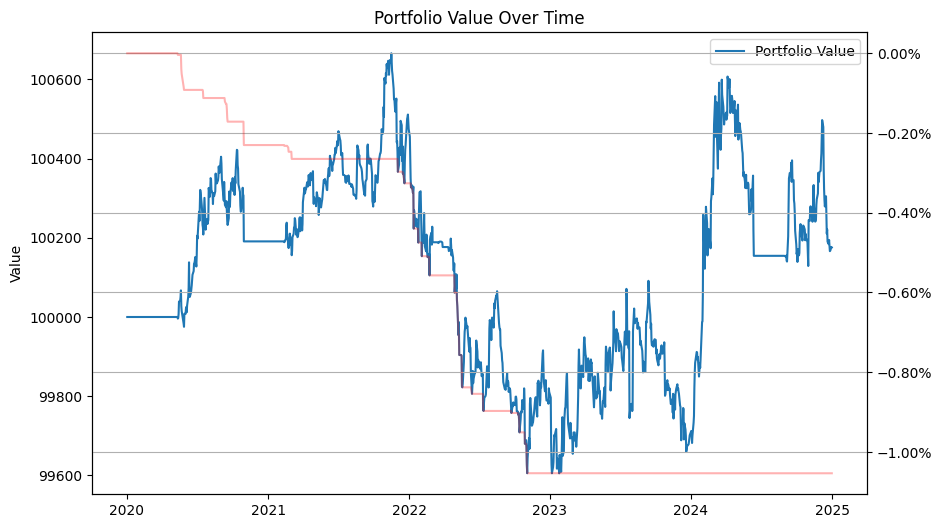

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax_maxdrawdn = ax.twinx()
ax_maxdrawdn.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.plot(df_vals, label="Portfolio Value")
ax_maxdrawdn.plot(drawdn*100, label="Drawdown", color='red', alpha=0.3)
# ax.fill_between(df_vals.index, df_vals["Value"], drawdn, color='red', alpha=0.3)

# if drawdn is not None:
#     ax.plot(drawdn, label="Drawdown", color='red', alpha=0.3)
#     ax.secondary_yaxis('right', functions=(lambda x: x, lambda x: str(x*100) + '%'))
ax.set_title("Portfolio Value Over Time")
ax.set_ylabel("Value")
ax.legend()
plt.grid(True)
# plt.tight_layout()